In [1]:
#import necessary libraries
import librosa as lbrs
import librosa.display
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
%matplotlib inline
import os
import pathlib
import csv 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras 
from keras import layers
from keras import layers
import keras
from keras.models import Sequential
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold
from scipy.io import wavfile
import warnings
warnings.filterwarnings('ignore')

In [3]:
#create headers foe the csv
header = 'filename rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate peak_frequency F_0'
for i in range(1, 21): #using 20 mel coefficients
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [52]:
#compiling the csv with spectral features and MFCCs
file = open('dataset_time+MFCC.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
grunts = 'isolation positive'.split()
for g in grunts:
    for filename in os.listdir(f'./grunts_final/{g}'):
        sound_name = f'./grunts_final/{g}/{filename}'
        y, sr = lbrs.load(sound_name, mono=True, duration=30)
        rms = lbrs.feature.rms(y=y)
        chroma_stft = lbrs.feature.chroma_stft(y=y, sr=sr)
        spec_cent = lbrs.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = lbrs.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = lbrs.feature.spectral_rolloff(y=y, sr=sr)
        zcr = lbrs.feature.zero_crossing_rate(y)
        peak_frequency = np.max(np.abs(lbrs.stft(y)))
        f0, voiced_flag, voiced_probs = lbrs.pyin(y, fmin=lbrs.note_to_hz('C2'), fmax=lbrs.note_to_hz('C7'))
        F0 = lbrs.times_like(f0)
        mfcc = lbrs.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)} {peak_frequency} {np.mean(F0)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('dataset_time+MFCC.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [4]:
#preparing the dataset 
data = pd.read_csv('dataset_time+MFCC.csv')
data.head()# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)
sound_list = data.iloc[:, -1] 
encoder = LabelEncoder()
y = encoder.fit_transform(sound_list) #encoding labels
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float)) #Scaling the Feature columns
#Dividing data into training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)
print(X.shape)

(567, 27)


[0.0501375  0.03600037 0.06618663 0.0304705  0.02254322 0.12151163
 0.07994203 0.04853705 0.03357592 0.02193428 0.03106756 0.03363662
 0.08861745 0.02170842 0.02143767 0.03552984 0.03531594 0.02954227
 0.01826329 0.02958082 0.02360474 0.03289004 0.02142292 0.02516744
 0.02401302 0.01736284]


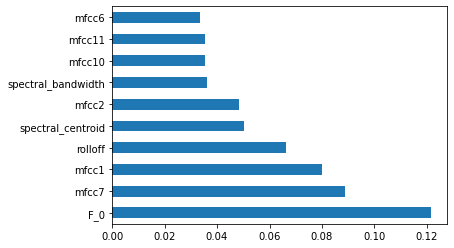

In [5]:
#feature importance
X_f = data.iloc[:,1:27]  #independent columns, not scaled
model = ExtraTreesClassifier() #randomized DT, more for insights on data
model.fit(X_f,sound_list)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_f.columns)
feat_importances.nlargest(10).plot(kind='barh')
plot.show()

In [7]:
# building the nerural network + a 10 cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
cvscores = []
for train, test in kfold.split(X, y):
  # create neural network
        model = Sequential()
        model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(1, activation='sigmoid')) 
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
	# Fit the model
        model.fit(X[train], y[train], epochs=80, batch_size=10, verbose=0)
	# evaluate the model with accuracy on 10 cv
        y_pred=model.predict(X[test])
    #confusion matrix for each cv
        preds=(y_pred >= 0.5).astype(np.float)
        cf_matrix=confusion_matrix(y[test], preds)
        print(cf_matrix)
        
        scores = model.evaluate(X[test], y[test], verbose=0)
        
    # print accuracy for each cv
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
#print overall accuracy and standard deviation
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
#The results here are slightly different from the ones in the thesis. 
#This is because I forgot to set a seed at the beginning but I still took the first result as good.  

[[28  4]
 [ 5 20]]
accuracy: 84.21%
[[30  2]
 [ 0 25]]
accuracy: 96.49%
[[27  5]
 [ 3 22]]
accuracy: 85.96%
[[31  1]
 [ 2 23]]
accuracy: 94.74%
[[31  1]
 [ 3 22]]
accuracy: 92.98%
[[31  1]
 [ 2 23]]
accuracy: 94.74%
[[28  4]
 [ 4 21]]
accuracy: 85.96%
[[31  1]
 [ 2 22]]
accuracy: 94.64%
[[29  3]
 [ 2 22]]
accuracy: 91.07%
[[29  2]
 [ 4 21]]
accuracy: 89.29%
91.01% (+/- 4.18%)


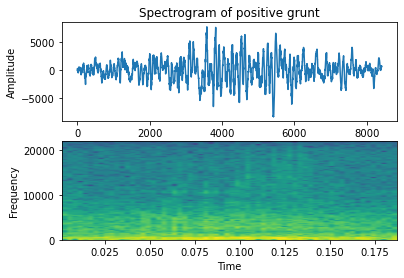

In [8]:
#Plotting oscillogram and spectrogram of positive grunt
# Read the wav file (mono)
samplingFrequency, signalData = wavfile.read('./grunts_final/Positive/positive-X-13.wav')
# Plot the signal read from wav file
plot.subplot(211)
plot.title('Spectrogram of positive grunt')
plot.plot(signalData)
plot.xlabel('Sample')
plot.ylabel('Amplitude')
plot.subplot(212)
plot.specgram(signalData,Fs=samplingFrequency)
plot.xlabel('Time')
plot.ylabel('Frequency')
plot.show()

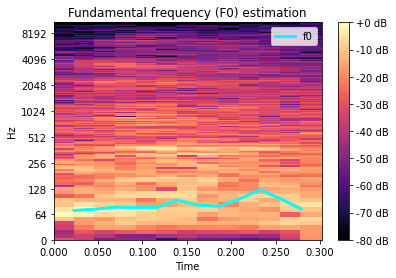

In [10]:
#plotting f0 of a positive grunt
y, sr = librosa.load('./grunts_final/Positive/positive-15-13.wav') 
f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
times = librosa.times_like(f0)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
fig, ax = plot.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='Fundamental frequency (F0) estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')